# Setup

## Imports

In [30]:
import os.path

from tqdm import tqdm_notebook
from time import time

OpenAI Gym Modules

In [31]:
import gym

vai Modules

In [32]:
from vai.vaidata import pickle_load, pickle_dump
from vai.utils.utils import path_consts

## Define Userful Features

In [33]:
np.seterr(over='ignore')

{'divide': 'warn', 'invalid': 'warn', 'over': 'ignore', 'under': 'ignore'}

In [34]:
for k, v in path_consts():
    exec(k + ' = v')

In [35]:
probabilistic = False

In [36]:
def get_parameters():
    return model.params

In [37]:
def set_parameters(parameters=None):
    if parameters is None: return
    global model
    model.params = parameters

In [81]:
def get_action(obs):
    l, h = env.observation_space.low, env.observation_space.high
    obs = (obs - l) * 2 / (h - l) - 1
    action = model(obs)
    if env.a == 1:
        return action
    elif env.a == 2:
        if probabilistic:
            return np.random.choice(2, p=[action[0], 1-action[0]])
        
        return (action > 0.5).astype(int)[0]
    elif probabilistic:
        return np.random.choice(env.a, p=action)
    
    return action.argmax()

In [39]:
def sample(episodes=1, observe=False):
    epoch_reward = 0
    for episode in range(episodes):
        env.reset()
        done = False
        obs = env.observation_space.sample()
        episode_reward = 0
        while not done:
            if observe:  env.render()
            obs, r, done, _ = env.step(get_action(obs))
            episode_reward += r
                
        epoch_reward += episode_reward
    if observe: env.render(close=True)
    return epoch_reward

In [40]:
def get_environment(environment='CartPole-v1'):
    env = gym.make(environment)

    env.n = env.observation_space.shape[0]
    env.a = env.action_space.shape
    env.a = env.action_space.n if len(env.a) == 0 else env.a[0]
    return env

In [41]:
env = get_environment()

In [42]:
num_episodes = 10
max_episode_reward = 500

# Create Model

In [43]:
def activate(x, activation):
    if activation == 'relu':
        x[x < 0] = 0
    elif activation == 'sigmoid':
        x = 1 / (1 + np.exp(-x))
    elif activation == 'tanh':
        x = np.tanh(x)
    elif activation == 'softmax':
        x -= x.max(-1, keepdims=True)
        x = np.exp(x)
        x /= x.sum(-1, keepdims=True)
    return x

In [44]:
class Linear():
    def __init__(self, in_features, out_features, activation=None):
        self.W_shape = (in_features, out_features)
        self.W_size = in_features * out_features
        self.b_size = out_features
        self.activation = activation
        self.num_parameters = self.W_size + self.b_size
        
    def __call__(self, x, params):
        W = params[:self.W_size].reshape(self.W_shape)
        b = params[self.W_size: self.W_size + self.b_size]
        
        return activate(x.dot(W) + b, self.activation)

In [45]:
class Model():
    def __init__(self, hidden_features=[], activation='tanh'):
        self.layers = self.__get_layers(hidden_features, activation)
        self.num_parameters = sum([layer.num_parameters for layer in self.layers])
        self.params = np.random.randn(self.num_parameters)
        
    def __call__(self, x):
        idx = 0
        for layer in self.layers:
            x = layer(x, self.params[idx:])
            idx += layer.num_parameters
        return x
        
    def __get_layers(self, hidden_features, activation):
        if len(hidden_features) == 0:
            if env.a == 2:
                layers = [Linear(env.n, 1, 'sigmoid')]
            else:
                layers = [Linear(env.n, env.a)]
        else:
            layers = [Linear(env.n, hidden_features[0], activation)]
            for i, h in enumerate(hidden_features[1:]):
                layers.append(Linear(hidden_features[i - 1], h, activation))
            
            if env.a == 1:
                layers.append(Linear(hidden_features[-1], 1))
            elif env.a == 2:
                layers.append(Linear(hidden_features[-1], 1, 'sigmoid'))
            else:
                layers.append(Linear(hidden_features[-1], env.a, 'softmax'))
        
        return layers

In [46]:
def get_model(hidden_features=[], activation='tanh'):
    return Model(hidden_features, activation)

In [47]:
model = get_model()

# Evolutionary Algorithms

## Define Base Features

In [48]:
def evaluate(parameters=None):
    set_parameters(parameters)
    return sample(num_episodes)

In [49]:
class EvolutionSearch():
    def __init__(self, show_progress=False):
        self.best_parameters = None
        self.best_reward = -np.inf
        self.epochs_run = 0
        self.show_progress = show_progress
        self.progress = []
        
    def search(self, num_epochs=-1, max_episode_reward=None, verbose=True, timeout=100):
        if self.epochs_run == 0:
            self.best_parameters = get_parameters()
            self.best_reward = evaluate()
            self.progress.append((0, self.best_reward))
            
        start_time = time()
        if num_epochs == -1:
            while self.best_reward / num_episodes < max_episode_reward:
                self._search(verbose)
                if time() - start_time > timeout: break
        else:
            epoch_iterator = range(num_epochs)
            if verbose: epoch_iterator = tqdm_notebook(epoch_iterator)
            for epoch in epoch_iterator:
                self._search(verbose)
                if time() - start_time > timeout: break
        set_parameters(self.best_parameters)
                
    def _search(self, verbose=True):
        pass

In [50]:
def plot_progress(optimizer):
    progress = np.array(optimizer.progress).T
    plot(progress[0], progress[1] / num_episodes)

## Random Search

Searches randomly and selects the best performing model

In [51]:
class RandomSearch(EvolutionSearch):
    def __init__(self, param_generator=lambda: np.random.randn(model.num_parameters).astype(np.float32),
                 show_progress=False):
        super().__init__(show_progress)
        self.param_generator = param_generator
        
    def _search(self, verbose=True):
        parameters = self.param_generator()
        reward = evaluate(parameters)
        self.epochs_run += 1
        
        if reward > self.best_reward:
            self.best_reward = reward
            self.best_parameters = parameters
            
            if verbose: print('Average reward:', int(reward / num_episodes), end='\r')
            self.progress.append((self.epochs_run, reward))
            if self.show_progress: sample(observe=True)

In [52]:
%%script false
optimizer = RandomSearch(show_progress=True)
optimizer.search(max_episode_reward=max_episode_reward)

plot_progress(optimizer)

## Spiral Search

Starts the search at a random point close to the best point and subsequently scans outwards. Although random, the pattern of searched points reminds one of a spiral.

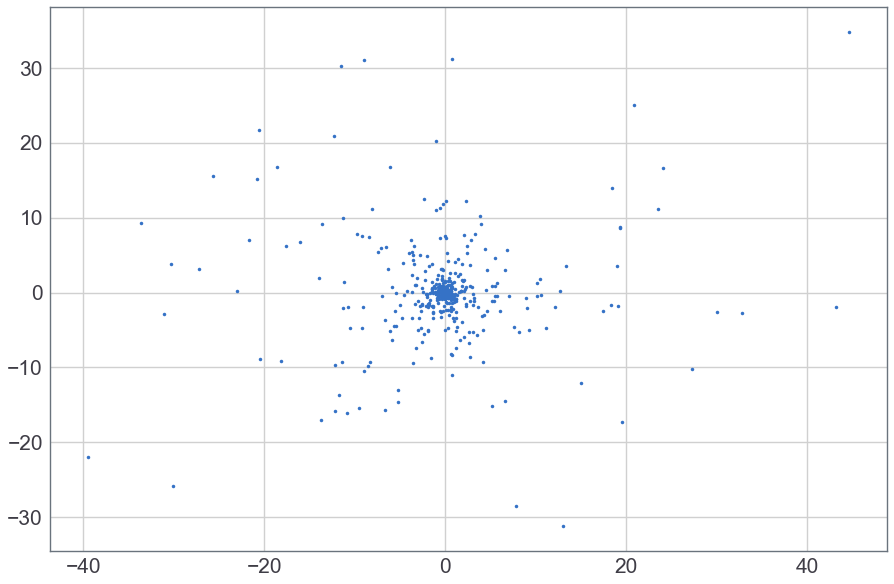

In [53]:
x = np.stack([np.random.randn(2) * 1e-3 * (1 + 1e-2) ** i for i in range(1000)]).T; plot(x[0], x[1], '.'); del x

In [106]:
class SpiralSearch(EvolutionSearch):
    def __init__(self, learning_rate=1e-3, spiral_rate=1e-2, show_progress=False, max_lr=np.inf):
        super().__init__(show_progress)
        self.initial_learning_rate = self.learning_rate = learning_rate
        self.spiral_rate = spiral_rate
        self.backward = False
        self.max_lr = max_lr
        
    def _search(self, verbose=True):
        noise = np.random.randn(model.num_parameters).astype(np.float32) * self.learning_rate
        parameters = self.best_parameters + noise
        reward = evaluate(parameters)
        self.epochs_run += 1
        self.__control_lr()
        
        if reward > self.best_reward:
            self.best_reward = reward
            self.best_parameters = parameters
            
            self.learning_rate = self.initial_learning_rate
            
            if verbose: print('Average reward:', int(reward / num_episodes), end='\r')
            self.progress.append((self.epochs_run, reward))
            if self.show_progress: sample(observe=True)
                
    def __control_lr(self):
        if self.backward:
            self.learning_rate *= (1 - self.spiral_rate)
        else:
            self.learning_rate *= (1 + self.spiral_rate)
            
        if self.learning_rate >= self.max_lr:
            self.backward = True
        elif self.learning_rate <= self.initial_learning_rate:
            self.backward = False

In [55]:
%%script false
model = get_model()

optimizer = SpiralSearch(show_progress=True)
optimizer.search(max_episode_reward=max_episode_reward)

plot_progress(optimizer)

## Evolutionary Strategy

Simple Evolutionary Strategy as proposed by OpenAI

In [104]:
class ESSearch(EvolutionSearch):
    def __init__(self, pop_size=50, learning_rate=1e-3, std=1e-1, spiral_rate=1e-2, show_progress=False, max_std=np.inf):
        super().__init__(show_progress)
        self.pop_size = pop_size
        self.learning_rate = learning_rate
        self.initial_std = self.std = std
        self.spiral_rate = spiral_rate
        self.max_std = max_std
        self.backward = False
        
    def _search(self, verbose=True):
        noises = np.random.randn(self.pop_size, model.num_parameters).astype(np.float32) * self.std
        rewards = np.stack([evaluate(self.best_parameters + noise) for noise in noises])
        self.epochs_run += 1
        
        if rewards.std == 0:
            self.__control_std()
            return

        rewards = (rewards - rewards.mean()) / rewards.std()
        self.best_parameters = self.best_parameters + self.learning_rate * noises.T.dot(rewards) / (self.pop_size * self.std)
        self.best_reward = evaluate(self.best_parameters)
        if verbose: print('Average reward:', int(self.best_reward / num_episodes), end='\r')
        self.progress.append((self.epochs_run, self.best_reward))
        
        if self.show_progress: sample(observe=True)
        
        self.std = self.initial_std
        self.backward = False
        
    def __control_std(self):
        if self.backward:
            self.std *= (1 - self.spiral_rate)
        else:
            self.std *= (1 + self.spiral_rate)
            
        if self.std >= self.max_std:
            self.backward = True
        elif self.std <= self.initial_std:
            self.backward = False

# Test Model

In [56]:
def optimize(environment='CartPole-v1', max_episode_reward=500, hidden_features=[],
             activation='relu', deterministic=True, optimizer=None, num_epochs=-1,
             verbose=True, timeout=100, episodes_per_epoch=10):
    global model, num_episodes, probabilistic, env
    env = get_environment(environment)
    model = get_model(hidden_features, activation)
    num_episodes = episodes_per_epoch
    probabilistic = not deterministic
    
    if optimizer is None: optimizer = RandomSearch()
    if type(optimizer) is str:
        optimizer = pickle_load(os.path.join(DIR_CHECKPOINTS, environment + '-' + optimizer + '.p'), has_lambda=True)

    optimizer.search(num_epochs, max_episode_reward, verbose, timeout)
    
    plot_progress(optimizer)
    
    pickle_dump(os.path.join(DIR_CHECKPOINTS, environment + '-optimizer.p'), optimizer, has_lambda=True)

In [112]:
optimize('LunarLander-v2', timeout=1, optimizer=SpiralSearch(show_progress=True), hidden_features=[10])

AttributeError: module 'Box2D._Box2D' has no attribute 'RAND_LIMIT'

In [111]:
sample(observe=True)

-1388.7166729305618